## Messages statistics from group chat in Messenger App ##

This project is based on Facebook/Meta available personal data for Messenger conversations.
Here I collected, clean-up and plotted some statistics for a group chat with me and some friends. He had more than 400,000 messages over more than 5 years.

This simple analysis focus on the time statistics for each participant: how much message each participant sends for a given period of the day, which days of the week they are more active and how that changed with years.

I also considered the 'react' dynamics (emojis that one can react to messagens among ourselves): who reacted more, who gets more reacts and how the participants reacted among themselves.

### Key points:
1) We are more active after 10am with message peaking around 8-9pm

2) Our messages are consistent for all days of week with more chat during 2020 (pandemic)

3) The overall reaction probability is around 4-12%

4) The most used emoji for react, by far, is 😆

5) Still need to fix the matplotlib emoji encoding

In [1]:
from os import listdir, system
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
from datetime import datetime, timezone, timedelta

In [11]:
# find all the message files to read
PATH = os.getcwd() + '\messages'
files = os.listdir(PATH)


# read .json files into dataframes
df = []
for file in files:
    if ('json' in file):
        with open('messages/' + file) as f:
            data = json.loads(f.read())
            df.append(pd.json_normalize(data, record_path=['messages']))
df = pd.concat(df)

#################################
# DATA PRE-PROCESSING & CLEANUP #
#################################


# hide the names
participant_list = list(df['sender_name'].unique())
participant_list.sort()
df['sender_name'] = df['sender_name'].apply(lambda x: 'Participant '+str(participant_list.index(x)+1))
df['reactions'] = df['reactions'].fillna('').apply(lambda x: np.nan if not x else [{'reaction':i['reaction'], 'actor':'Participant '+str(participant_list.index(i['actor'])+1)} for i in x])


# add column for pd.datetime object
# here I am not accounting for daylight saving time
# subtracting -3h to convert from UTC to Brazil time
df['datetime'] = pd.to_datetime(df['timestamp_ms'],unit='ms')
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['weekday']= df['datetime'].dt.weekday
df['hour'] = (pd.to_datetime(df['datetime']) + pd.DateOffset(hours=-3)).dt.hour


# removing messages that are logs for reactions
df = df[df['content'].str.contains("reagiu com")==False]
df = df[df['content'].str.contains("reacted with")==False]


# encoding emojis correctly, from latin1 to utf8
df['content'] = df['content'].apply(lambda x: x.encode('latin1').decode('utf8'))
df['reactions'] = df['reactions'].fillna('').apply(lambda x: np.nan if not x else [{'reaction':i['reaction'].encode('latin1').decode('utf8'), 'actor':i['actor']} for i in x])


# removing duplicate reactions
df['reactions'] = df['reactions'].fillna('').apply(lambda x: np.nan if not x else [i for n, i in enumerate(x) if i not in x[n+1:]])


# number of messages per participant
df.groupby('sender_name').size()

sender_name
Participant 1     84691
Participant 2      1791
Participant 3    123589
Participant 4     59085
Participant 5    147107
dtype: int64

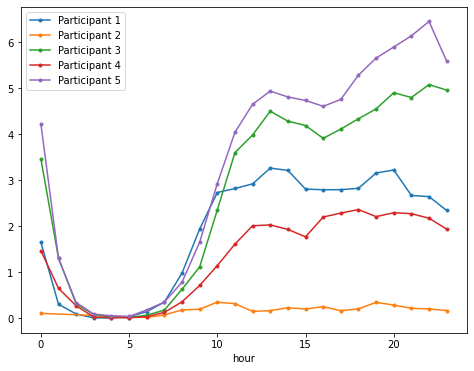

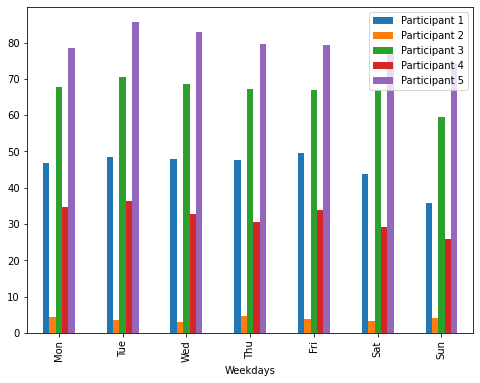

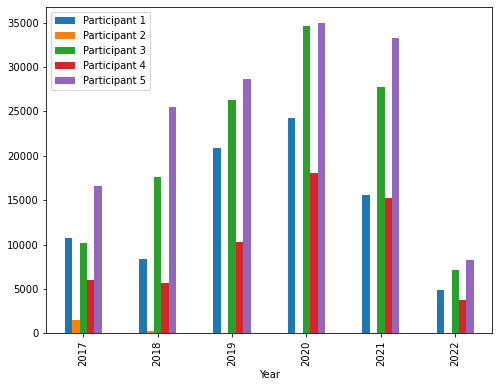

In [24]:
##################################################################################
# STATISTICS OF MESSAGES PER HOUR, PER WEEKDAY AND PER YEAR FOR EACH PARTICIPANT #
# WE SEE THEY ARE MORE ACTIVE AT NIGHT AND DURING WEEKDAYS                       #
##################################################################################


# total number of days for each participant
df_numdays = df.groupby('sender_name').agg(min=('datetime','min'), max=('datetime','max'))
df_numdays['num_days'] = (df_numdays['max']-df_numdays['min']).dt.days


# statics of message per time
# USING GROUPBY
df_time = df.groupby([df['sender_name'], df['year'], df['month'], df['weekday'], df['hour']], as_index=False).agg({'type':'count'}).rename(columns={'type':'count'})


# messages per person per hour
df_hour = df_time.groupby([df_time['sender_name'], df_time['hour']], as_index=False).agg({'count':'sum'}).rename(columns={'count':'sum'})
df_hour = df_hour.join(df_numdays, on='sender_name')
df_hour['mean'] = df_hour['sum'].div(df_hour['num_days'])
df_hour.set_index('hour', inplace=True)
fig = plt.figure()
df_hour.groupby('sender_name')['mean'].plot(marker='.', figsize=(8,6))
plt.legend(loc='best')
plt.show()
fig.savefig('results/msg_hour.png')


# messages per person per weekday
# using PIVOT
df_day = df_time.groupby([df_time['sender_name'], df_time['weekday']], as_index=False).agg({'count':'sum'}).rename(columns={'count':'sum'})
df_day = df_day.join(df_numdays, on='sender_name')
df_day['mean'] = df_day['sum'].div(df_day['num_days'])*7
df_day = df_day.pivot(index='weekday', columns='sender_name', values='mean')
fig = df_day.plot(kind='bar', figsize=(8,6)).get_figure()
plt.xlabel('Weekdays')
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=['Mon','Tue', 'Wed','Thu','Fri','Sat', 'Sun'])
plt.legend(loc='upper right')
plt.show()
fig.savefig('results/msg_weekday.png')


# messages per year
# using PIVOT
df_year = df_time.groupby([df_time['sender_name'], df_time['year']], as_index=False).agg({'count':'sum'}).rename(columns={'count':'sum'})
df_year = df_year.pivot(index='year', columns='sender_name', values='sum')
fig = df_year.plot(kind='bar', figsize=(8,6)).get_figure()
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.show()
fig.savefig('results/msg_year.png')

<ipython-input-25-fa17fc550b14>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_react[participant] = create_reaction_column(df_react, participant)
c:\Users\guilh\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 55357 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\guilh\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 56838 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\guilh\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 56397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\guilh\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:2

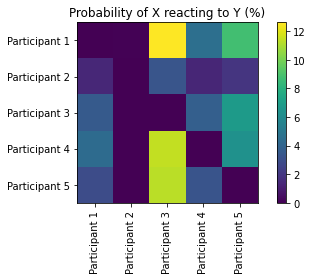

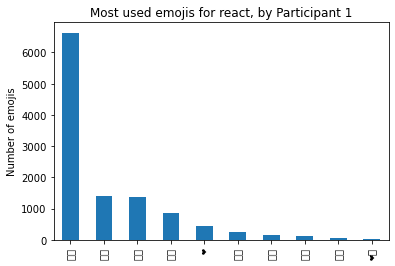

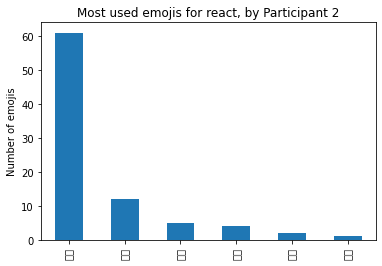

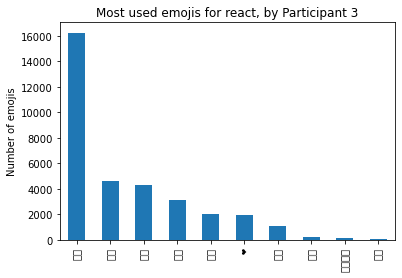

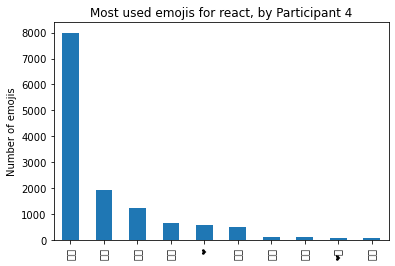

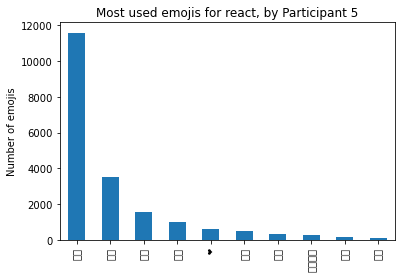

In [25]:
###########################
# STATISTICS ON REACTIONS #
###########################


# list of participants
participant_list = list(df['sender_name'].unique())
participant_list.sort()


# remove messages with empty reactions
df_react = df[['sender_name', 'content', 'reactions', 'datetime']]


# extract reacts for each message and create additional columns
def extract_reaction(reaction_list, name):
    for reaction in reaction_list:
        if reaction['actor'] ==  name:
            return reaction['reaction']

def create_reaction_column(df, participant):
    return df['reactions'].fillna('').apply(lambda x: np.nan if not x else extract_reaction(x,participant))

for participant in participant_list:
    df_react[participant] = create_reaction_column(df_react, participant)


# matrix of probability of person X to react to message of person Y
# Prob = #(reacts X gave to Y) / #(total messages of Y)
matrix_react = np.zeros((len(participant_list), len(participant_list)))
df_react_count = df_react.groupby(['sender_name'], as_index=False).agg('count')
for i in range(len(participant_list)):
    for j in range(len(participant_list)):
        pass
        matrix_react[i,j] = 100*int(df_react_count[df_react_count['sender_name']==participant_list[i]][participant_list[j]]) 
        matrix_react[i,j] /= int(df_react_count[df_react_count['sender_name']==participant_list[i]]['content'])
fig = plt.figure()
plt.imshow(matrix_react)
plt.title("Probability of X reacting to Y (%)")
plt.xticks(ticks=[i for i in range(len(participant_list))], labels=participant_list, rotation=90)
plt.yticks(ticks=[i for i in range(len(participant_list))], labels=participant_list)
plt.colorbar()
fig.tight_layout()
plt.savefig('results/matrix_react.png')


# histogram of emojis for each participant
# TODO: fix the encoding of emojis to show on matplotlib
for participant in participant_list:
    dfg = df_react.groupby([participant]).size().to_frame().sort_values([0], ascending = False).head(10).reset_index()
    #print(dfg)
    ax = dfg.plot.bar()
    fig = ax.get_figure()
    ax.set_xticklabels([i for i in dfg[participant]], fontname='DejaVu Sans Mono')
    ax.set_title('Most used emojis for react, by '+participant)
    ax.set_ylabel('Number of emojis')
    ax.get_legend().remove()
    fig.savefig('results/emoji_'+participant+'.png')